In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import SubplotDivider, Size
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import windrose 
from windrose import WindroseAxes 
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go

In [4]:
warnings.filterwarnings('ignore')
%matplotlib inline

### Use BARRA ua850hPa data to determine wind direction/speeds

In [5]:
def open_barra_files(variable_u,variable_v,lat,lon):
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
            "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
            "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
            "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
            "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
            "201203-201203","201204-201204"
           ] #"202203-202203","202204-202204": removed as not in radar domain; barra goes back to 2007 (radar till 08-2011)
    fp_u = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/"+variable_u+"/"
    fp_v = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/"+variable_v+"/"
    u_data = []
    v_data = []
    for months in list:
        # to get specific hour, edit: u.ua850.isel(time=(barra2_202201.time.dt.hour == hour)
        u = xr.open_dataset(fp_u+variable_u+"_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_"+months+".nc", engine="netcdf4")#,decode_times=False)
        u_mean = u.ua850.sel(lat=lat,lon=lon,method="nearest").mean(dim=["lat","lon"])    # chunks={} does lazy loading - ends up slower
        u_data.append(u_mean)
        v = xr.open_dataset(fp_v+variable_v+"_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_"+months+".nc", engine="netcdf4")
        v_mean = v.va850.sel(lat=lat,lon=lon,method="nearest").mean(dim=["lat","lon"])    
        v_data.append(v_mean)
    return u_data,v_data 

In [7]:
wind_mean = open_barra_files("ua850","va850",[-20.768799,-18.0708],[145.12054,147.9812]) #townsville
#wind_mean = open_files("ua850","va850",[-18.165955,-15.468018],[144.27374,147.09222]) #cairns
#wind_mean = open_files("ua850","va850",[-17.636353,-14.938416],[148.55927,151.36993]) #willis island

KeyboardInterrupt: 

In [5]:
u = wind_mean[0]
v = wind_mean[1]
concat_u = xr.concat([u[0],u[1],u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9],u[10],u[11],u[12],u[13],u[14],u[15],u[16],u[17],u[18],u[19],u[20],
                      u[21],u[22],u[23],u[24],u[25],u[26],u[27],u[28],u[29],u[30],u[31],u[32],u[33],u[34],u[35],u[36],u[37],u[38],u[39],u[40],
                      u[41]],
                      "time")
concat_v = xr.concat([v[0],v[1],v[2],v[3],v[4],v[5],v[6],v[7],v[8],v[9],v[10],v[11],v[12],v[13],v[14],v[15],v[16],v[17],v[18],v[19],v[20],
                      v[21],v[22],v[23],v[24],v[25],v[26],v[27],v[28],v[29],v[30],v[31],v[32],v[33],v[34],v[35],v[36],v[37],v[38],v[39],v[40],
                      v[41]],
                     "time")
uu = concat_u * units("m/s")
vv = concat_v * units("m/s")
wind_dir = metpy.calc.wind_direction(uu, vv, convention='from')
wind_speed = metpy.calc.wind_speed(uu, vv)
direction = wind_dir.values
speed = wind_speed.values

# speeding up process/keeping more info within data

In [ ]:
# filepath to BARRA wind data
fp_u = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/ua850/"
fp_v = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/va850/"

# create array listing all nc files within the wind variable of interest and sort
file_list_u = [f for f in os.listdir(fp_u) if f.endswith('.nc')]
file_list_u.sort()
file_list_v = [f for f in os.listdir(fp_v) if f.endswith('.nc')]
file_list_v.sort()

# don't need to open all files, specify only later files
files_u = file_list_u[124:128]+file_list_u[136:140]+file_list_u[148:152]+file_list_u[160:164]+file_list_u[172:176]
files_v = file_list_v[124:128]+file_list_v[136:140]+file_list_v[148:152]+file_list_v[160:164]+file_list_v[172:176]

# create array which lists entire file path with dates wanted
fp_ua850 = []
fp_va850 = []
for i in range(len(files_u)):
    fp_ua850.append(fp_u+files_u[i])
for i in range(len(files_v)):
    fp_va850.append(fp_v+files_v[i])

In [5]:
# open dataset
dataset_ua850 = xr.open_mfdataset(fp_ua850,combine="by_coords",parallel=True,chunks={'time': 'auto'})
dataset_va850 = xr.open_mfdataset(fp_va850,combine="by_coords",parallel=True,chunks={'time': 'auto'})

In [6]:
u_meanT = dataset_ua850.ua850.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest")
ua850meanT = u_meanT.mean(dim=["lat","lon"]).compute()

In [7]:
v_meanT = dataset_va850.va850.sel(lat=[-20.768799,-18.0708],lon=[145.12054,147.9812],method="nearest")
va850meanT = v_meanT.mean(dim=["lat","lon"]).compute()

In [27]:
# assign units to u and v values
uT = ua850meanT.values * units("m/s")
vT = va850meanT.values * units("m/s")

# metpy calculations for windrose inputs 
wind_dir = metpy.calc.wind_direction(uT, vT, convention='from')
wind_speed = metpy.calc.wind_speed(uT, vT)
direction = wind_dir.magnitude
speed = wind_speed.magnitude

In [36]:
easterlies4 = wind_dir[(wind_dir>=90*units("degree"))&(wind_dir<120*units("degree"))]
#eaterly_times4 = easterlies4.time.values
wind_dir

Magnitude,[329.3013916015625 328.30810546875 328.5205383300781 ... 119.36647033691406 114.91785430908203 114.49263763427734]
Units,degree


# Using time data from BARRA, look at precip rain rate from radar

In [8]:
# open nc files JFMA 2018-2022
list = ["202201","202202","202203","202204","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
        "201801","201802","201803","201804"]
# open townsville radar data JFMA
filesT = []
#filesW = []
for i in list:
    fp_T = "/g/data/rq0/level_2/73/RAINRATE/"
    #fp_W = "/g/data/rq0/level_2/41/RAINRATE/"
    files_T = [os.path.join(root, f) for root, _, files in os.walk(fp_T)
        for f in files
        if f.startswith('73_'+i) and f.endswith('.nc')]
    filesT.extend(files_T)
filesT.sort()
ds_T = xr.open_mfdataset(filesT, engine="netcdf4")

In [20]:
# categorise rr values, include zero mm/hr
def categorise_rr(wind_dir_rr_values):
    group1W = [num for num in wind_dir_rr_values if 0.0 <= num <= 0.033]
    group2W = [num for num in wind_dir_rr_values if 0.033 < num <= 0.5]
    group3W = [num for num in wind_dir_rr_values if 0.5 < num <= 1]
    group4W = [num for num in wind_dir_rr_values if 1 < num <= 1.5]
    group5W = [num for num in wind_dir_rr_values if num > 1.5]
    return [group1W,group2W,group3W,group4W,group5W]

# Precip rose data prep

In [9]:
# using magnitude (convert to degrees), select data between 180-360 degrees, 
easterlies1 = wind_dir[(wind_dir>=0*units("degree"))&(wind_dir<30*units("degree"))]
easterlies2 = wind_dir[(wind_dir>=30*units("degree"))&(wind_dir<60*units("degree"))]
easterlies3 = wind_dir[(wind_dir>=60*units("degree"))&(wind_dir<90*units("degree"))]
easterlies4 = wind_dir[(wind_dir>=90*units("degree"))&(wind_dir<120*units("degree"))]
easterlies5 = wind_dir[(wind_dir>=120*units("degree"))&(wind_dir<150*units("degree"))]
easterlies6 = wind_dir[(wind_dir>=150*units("degree"))&(wind_dir<180*units("degree"))]
westerlies1 = wind_dir[(wind_dir>=180*units("degree"))&(wind_dir<210*units("degree"))]
westerlies2 = wind_dir[(wind_dir>=210*units("degree"))&(wind_dir<240*units("degree"))]
westerlies3 = wind_dir[(wind_dir>=240*units("degree"))&(wind_dir<270*units("degree"))]
westerlies4 = wind_dir[(wind_dir>=270*units("degree"))&(wind_dir<300*units("degree"))]
westerlies5 = wind_dir[(wind_dir>=300*units("degree"))&(wind_dir<330*units("degree"))]
westerlies6 = wind_dir[330*units("degree")<wind_dir]
# select time values
eaterly_times1 = easterlies1.time.values
eaterly_times2 = easterlies2.time.values
eaterly_times3 = easterlies3.time.values
eaterly_times4 = easterlies4.time.values
eaterly_times5 = easterlies5.time.values
eaterly_times6 = easterlies6.time.values
westerly_times1 = westerlies1.time.values
westerly_times2 = westerlies2.time.values
westerly_times3 = westerlies3.time.values
westerly_times4 = westerlies4.time.values
westerly_times5 = westerlies5.time.values
westerly_times6 = westerlies6.time.values

# sort so index is more similar to radar time index
eaterly_times1.sort()
eaterly_times2.sort()
eaterly_times3.sort()
eaterly_times4.sort()
eaterly_times5.sort()
eaterly_times6.sort()
westerly_times1.sort() 
westerly_times2.sort() 
westerly_times3.sort() 
westerly_times4.sort() 
westerly_times5.sort() 
westerly_times6.sort() 

In [10]:
# select radar data times which closest equal to westerly times
ds_T_easterlies1 = ds_T.sel(time=eaterly_times1,method="nearest") 
ds_T_easterlies2 = ds_T.sel(time=eaterly_times2,method="nearest") 
ds_T_easterlies3 = ds_T.sel(time=eaterly_times3,method="nearest") 
ds_T_easterlies4 = ds_T.sel(time=eaterly_times4,method="nearest") 
ds_T_easterlies5 = ds_T.sel(time=eaterly_times5,method="nearest") 
ds_T_easterlies6 = ds_T.sel(time=eaterly_times6,method="nearest") 
ds_T_westerlies1 = ds_T.sel(time=westerly_times1,method="nearest")
ds_T_westerlies2 = ds_T.sel(time=westerly_times2,method="nearest")
ds_T_westerlies3 = ds_T.sel(time=westerly_times3,method="nearest")
ds_T_westerlies4 = ds_T.sel(time=westerly_times4,method="nearest")
ds_T_westerlies5 = ds_T.sel(time=westerly_times5,method="nearest")
ds_T_westerlies6 = ds_T.sel(time=westerly_times6,method="nearest")

# find mean rr's
rr_mean0_30 = ds_T_easterlies1.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean30_60 = ds_T_easterlies2.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean60_90 = ds_T_easterlies3.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean90_120 = ds_T_easterlies4.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean120_150 = ds_T_easterlies5.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean150_180 = ds_T_easterlies6.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean180_210 = ds_T_westerlies1.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean210_240 = ds_T_westerlies2.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean240_270 = ds_T_westerlies3.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean270_300 = ds_T_westerlies4.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean300_330 = ds_T_westerlies5.rainrate.mean(dim=["x","y"],skipna=True)
rr_mean330_360 = ds_T_westerlies6.rainrate.mean(dim=["x","y"],skipna=True) #mean across x, y plane

# new array
E_values1 = []
E_values2 = []
E_values3 = []
E_values4 = []
E_values5 = []
E_values6 = []
W_values1 = []
W_values2 = []
W_values3 = []
W_values4 = []
W_values5 = []
W_values6 = []
E_values1.extend(rr_mean0_30.values)
E_values2.extend(rr_mean30_60.values)
E_values3.extend(rr_mean60_90.values)
E_values4.extend(rr_mean90_120.values)
E_values5.extend(rr_mean120_150.values)
E_values6.extend(rr_mean150_180.values)
W_values1.extend(rr_mean180_210.values)
W_values2.extend(rr_mean210_240.values)
W_values3.extend(rr_mean240_270.values)
W_values4.extend(rr_mean270_300.values)
W_values5.extend(rr_mean300_330.values)
W_values6.extend(rr_mean330_360.values)

In [11]:
# get westerly values
def categorise_rr(wind_dir_rr_values):
    group1W = [num for num in wind_dir_rr_values if 0.0 < num <= 0.5]
    group2W = [num for num in wind_dir_rr_values if 0.5 < num <= 1]
    group3W = [num for num in wind_dir_rr_values if 1 < num <= 2]
    group4W = [num for num in wind_dir_rr_values if 2 < num <= 4]
    group5W = [num for num in wind_dir_rr_values if 4 < num <= 8]
    group6W = [num for num in wind_dir_rr_values if num > 8]
    return [group1W,group2W,group3W,group4W,group5W,group6W]
rr_E1 = categorise_rr(E_values1)
rr_E2 = categorise_rr(E_values2)
rr_E3 = categorise_rr(E_values3)
rr_E4 = categorise_rr(E_values4)
rr_E5 = categorise_rr(E_values5)
rr_E6 = categorise_rr(E_values6)
rr_W1 = categorise_rr(W_values1)
rr_W2 = categorise_rr(W_values2)
rr_W3 = categorise_rr(W_values3)
rr_W4 = categorise_rr(W_values4)
rr_W5 = categorise_rr(W_values5)
rr_W6 = categorise_rr(W_values6)

In [12]:
# create array with counts for each rr category and each direction info
counts = [
    [len(rr_E1[0]),len(rr_E2[0]),len(rr_E3[0]),len(rr_E4[0]),len(rr_E5[0]),len(rr_E6[0]),len(rr_W1[0]),len(rr_W2[0]),len(rr_W3[0]),len(rr_W4[0]),len(rr_W5[0]),len(rr_W6[0])],    
    [len(rr_E1[1]),len(rr_E2[1]),len(rr_E3[1]),len(rr_E4[1]),len(rr_E5[1]),len(rr_E6[1]),len(rr_W1[1]),len(rr_W2[1]),len(rr_W3[1]),len(rr_W4[1]),len(rr_W5[1]),len(rr_W6[1])],
    [len(rr_E1[2]),len(rr_E2[2]),len(rr_E3[2]),len(rr_E4[2]),len(rr_E5[2]),len(rr_E6[2]),len(rr_W1[2]),len(rr_W2[2]),len(rr_W3[2]),len(rr_W4[2]),len(rr_W5[2]),len(rr_W6[2])],
    [len(rr_E1[3]),len(rr_E2[3]),len(rr_E3[3]),len(rr_E4[3]),len(rr_E5[3]),len(rr_E6[3]),len(rr_W1[3]),len(rr_W2[3]),len(rr_W3[3]),len(rr_W4[3]),len(rr_W5[3]),len(rr_W6[3])],
    [len(rr_E1[4]),len(rr_E2[4]),len(rr_E3[4]),len(rr_E4[4]),len(rr_E5[4]),len(rr_E6[4]),len(rr_W1[4]),len(rr_W2[4]),len(rr_W3[4]),len(rr_W4[4]),len(rr_W5[4]),len(rr_W6[4])],
    [len(rr_E1[5]),len(rr_E2[5]),len(rr_E3[5]),len(rr_E4[5]),len(rr_E5[5]),len(rr_E6[5]),len(rr_W1[5]),len(rr_W2[5]),len(rr_W3[5]),len(rr_W4[5]),len(rr_W5[5]),len(rr_W6[5])]
]
# westerlies only
#counts = [
#    [len(rr_W1[0]),len(rr_W2[0]),len(rr_W3[0]),len(rr_W4[0]),len(rr_W5[0]),len(rr_W6[0])],    
#    [len(rr_W1[1]),len(rr_W2[1]),len(rr_W3[1]),len(rr_W4[1]),len(rr_W5[1]),len(rr_W6[1])],
#    [len(rr_W1[2]),len(rr_W2[2]),len(rr_W3[2]),len(rr_W4[2]),len(rr_W5[2]),len(rr_W6[2])],
#    [len(rr_W1[3]),len(rr_W2[3]),len(rr_W3[3]),len(rr_W4[3]),len(rr_W5[3]),len(rr_W6[3])],
#    [len(rr_W1[4]),len(rr_W2[4]),len(rr_W3[4]),len(rr_W4[4]),len(rr_W5[4]),len(rr_W6[4])],
#   [len(rr_W1[5]),len(rr_W2[5]),len(rr_W3[5]),len(rr_W4[5]),len(rr_W5[5]),len(rr_W6[5])]
#]

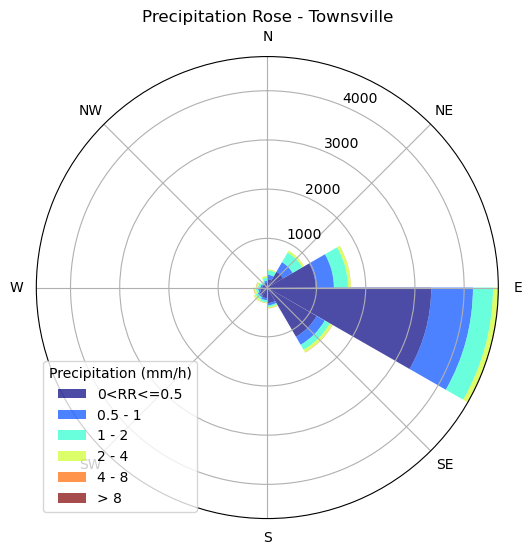

In [59]:
# define stacked bar polar plot
def stacked_bar_polar_plot(data,rr_category,rr_values):
    num_categories = len(rr_category)
    num_samples = len(data)

    # create plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111,polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    # pie slices
    angles = [0.0,(1/6)*np.pi,(2/6)*np.pi,(3/6)*np.pi,(4/6)*np.pi,(5/6)*np.pi,1*np.pi,(7/6)*np.pi,(8/6)*np.pi,(9/6)*np.pi,(10/6)*np.pi,(11/6)*np.pi]
    #angles = [1*np.pi,(7/6)*np.pi,(8/6)*np.pi,(9/6)*np.pi,(10/6)*np.pi,(11/6)*np.pi]
    width = [0.52]
    
    # stack bars
    bottom = np.zeros(12)
    colors = plt.cm.get_cmap("jet",num_categories)
    for i in range(num_samples):
        ax.bar(angles,data[i],width=width,bottom=bottom,alpha=0.7,color=colors(i),align="edge")
        bottom +=data[i]
    
    # set group labels
    custom_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW','W','NW']
    theta = [0.0,(1/4) * np.pi,(2/4) * np.pi,(3/4) * np.pi,(4/4) * np.pi,(5/4) * np.pi,(6/4) * np.pi,(7/4) * np.pi]
    ax.set_xticks(theta)
    ax.set_xticklabels(custom_labels)
    
    # set title
    ax.set_title("Precipitation Rose - Townsville")

    # set legend
    ax.legend(title="Precipitation (mm/h)",labels=[rr_values[0],rr_values[1],rr_values[2],rr_values[3],rr_values[4],rr_values[5]],loc="lower left")
    plt.show()
rr_values = ["0<RR<=0.5","0.5 - 1","1 - 2","2 - 4","4 - 8","> 8"]
stacked_bar_polar_plot(counts,rr_values,rr_values)


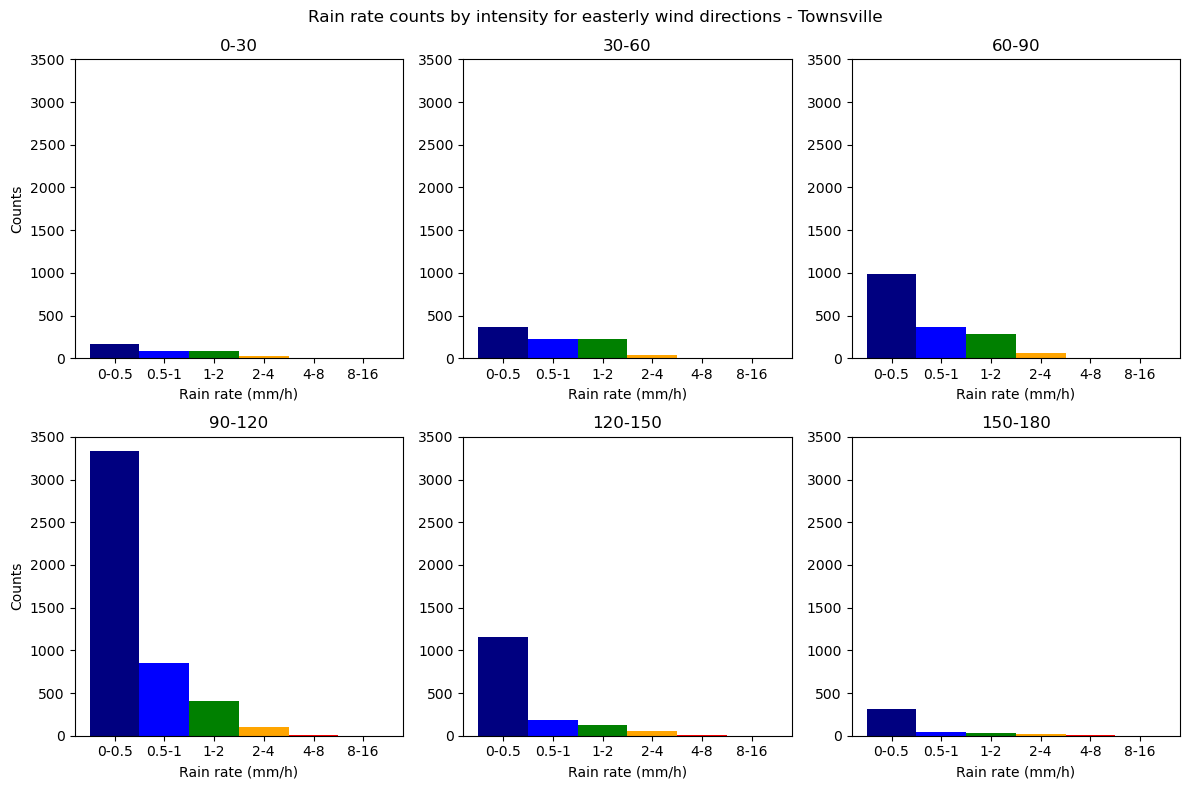

In [14]:
rr_W1 = categorise_rr(W_values1)
rr_W2 = categorise_rr(W_values2)
rr_W3 = categorise_rr(W_values3)
rr_W4 = categorise_rr(W_values4)
rr_W5 = categorise_rr(W_values5)
rr_W6 = categorise_rr(W_values6)
bins = [0,0.5,1,2,4,8,16]

# create subplots
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
counts_bar = [
    [len(rr_E1[0]),len(rr_E1[1]),len(rr_E1[2]),len(rr_E1[3]),len(rr_E1[4]),len(rr_E1[5])],
    [len(rr_E2[0]),len(rr_E2[1]),len(rr_E2[2]),len(rr_E2[3]),len(rr_E2[4]),len(rr_E2[5])],
    [len(rr_E3[0]),len(rr_E3[1]),len(rr_E3[2]),len(rr_E3[3]),len(rr_E3[4]),len(rr_E3[5])],
    [len(rr_E4[0]),len(rr_E4[1]),len(rr_E4[2]),len(rr_E4[3]),len(rr_E4[4]),len(rr_E4[5])],
    [len(rr_E5[0]),len(rr_E5[1]),len(rr_E5[2]),len(rr_E5[3]),len(rr_E5[4]),len(rr_E5[5])],
    [len(rr_E6[0]),len(rr_E6[1]),len(rr_E6[2]),len(rr_E6[3]),len(rr_E6[4]),len(rr_E6[5])],
   # [len(rr_W1[0]),len(rr_W1[1]),len(rr_W1[2]),len(rr_W1[3]),len(rr_W1[4]),len(rr_W1[5])],
   # [len(rr_W2[0]),len(rr_W2[1]),len(rr_W2[2]),len(rr_W2[3]),len(rr_W2[4]),len(rr_W2[5])],
   # [len(rr_W3[0]),len(rr_W3[1]),len(rr_W3[2]),len(rr_W3[3]),len(rr_W3[4]),len(rr_W3[5])],
   # [len(rr_W4[0]),len(rr_W4[1]),len(rr_W4[2]),len(rr_W4[3]),len(rr_W4[4]),len(rr_W4[5])],
   # [len(rr_W5[0]),len(rr_W5[1]),len(rr_W5[2]),len(rr_W5[3]),len(rr_W5[4]),len(rr_W5[5])],
   # [len(rr_W6[0]),len(rr_W6[1]),len(rr_W6[2]),len(rr_W6[3]),len(rr_W6[4]),len(rr_W6[5])]
]
rr_cat_length = np.arange(0,6,1)
bar_width = 1
colors = ['navy', 'blue', 'green', 'orange', 'red']
ax[0,0].bar(rr_cat_length,counts_bar[0], color=colors, width=bar_width, align='center')
ax[0,1].bar(rr_cat_length,counts_bar[1], color=colors, width=bar_width, align='center')
ax[0,2].bar(rr_cat_length,counts_bar[2], color=colors, width=bar_width, align='center')
ax[1,0].bar(rr_cat_length,counts_bar[3], color=colors, width=bar_width, align='center')
ax[1,1].bar(rr_cat_length,counts_bar[4], color=colors, width=bar_width, align='center')
ax[1,2].bar(rr_cat_length,counts_bar[5], color=colors, width=bar_width, align='center')

# x ticks and xtick labels
rr_values = ["0-0.5","0.5-1","1-2","2-4","4-8","8-16"]
ax[0,0].set_xticks(rr_cat_length)
ax[0,0].set_xticklabels(rr_values)
ax[0,0].set_xlabel("Rain rate (mm/h)")
ax[0,1].set_xticks(rr_cat_length)
ax[0,1].set_xticklabels(rr_values)
ax[0,1].set_xlabel("Rain rate (mm/h)")
ax[0,2].set_xticks(rr_cat_length)
ax[0,2].set_xticklabels(rr_values)
ax[0,2].set_xlabel("Rain rate (mm/h)")
ax[1,0].set_xticks(rr_cat_length)
ax[1,0].set_xticklabels(rr_values)
ax[1,0].set_xlabel("Rain rate (mm/h)")
ax[1,1].set_xticks(rr_cat_length)
ax[1,1].set_xticklabels(rr_values)
ax[1,1].set_xlabel("Rain rate (mm/h)")
ax[1,2].set_xticks(rr_cat_length)
ax[1,2].set_xticklabels(rr_values)
ax[1,2].set_xlabel("Rain rate (mm/h)")
# set y labels
ax[0,0].set_ylabel("Counts")
ax[1,0].set_ylabel("Counts")
ax[0,0].set_ylim(0,3500)
ax[0,1].set_ylim(0,3500)
ax[0,2].set_ylim(0,3500)
ax[1,0].set_ylim(0,3500)
ax[1,1].set_ylim(0,3500)
ax[1,2].set_ylim(0,3500)

# set plot labels
fig.suptitle("Rain rate counts by intensity for easterly wind directions - Townsville")
ax[0,0].set_title("0-30") #"180-210") 
ax[0,1].set_title("30-60")# "210-240") #
ax[0,2].set_title("60-90") #"240-270") #
ax[1,0].set_title("90-120")#"270-300") #
ax[1,1].set_title("120-150")#"300-330") #"
ax[1,2].set_title("150-180")#"330-360") #

plt.tight_layout()

In [64]:
eaterly_times1 = easterlies1.time.values
print(len(eaterly_times1))
eaterly_times2 = easterlies2.time.values
print(len(eaterly_times2))
eaterly_times3 = easterlies3.time.values
print(len(eaterly_times3))
eaterly_times4 = easterlies4.time.values
print(len(eaterly_times4))
eaterly_times5 = easterlies5.time.values
print(len(eaterly_times5))
eaterly_times6 = easterlies6.time.values
print(len(eaterly_times6))
westerly_times1 = westerlies1.time.values
print(len(westerly_times1))
westerly_times2 = westerlies2.time.values
print(len(westerly_times2))
westerly_times3 = westerlies3.time.values
print(len(westerly_times3))
westerly_times4 = westerlies4.time.values
print(len(westerly_times4))
westerly_times5 = westerlies5.time.values
print(len(westerly_times5))
westerly_times6 = westerlies6.time.values
print(len(westerly_times6))

393
898
1776
5318
2179
534
421
427
339
252
179
244
